# Logistic Regression: Motivation

In the precourse assignments you implemented gradient descent for Linear Regression. In this notebook, we will look at ___(Binary) Logistic Regression___. As we will see in the next couple of weeks, this model class is useful for many machine learning applications in marketing.

Specifically, we will look at three aspects:
1. the distribution of the dependent variable
1. the functional form of the Logit curve
1. probability thresholds

As a bonus, we will also see how we can model more complex (i.e., non-linear) decision boundaries. This part is really exciting :)

## Imports

In [1]:
import os

import common
import IPython.display
import ipywidgets
import matplotlib.colors
import matplotlib.patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm

## Background

### Formal representation of the problem

Let's look at a binary classification model

$
\quad y_i = \cases{1 \quad \text{if}\ z_i^* > 0\\0 \quad \text{otherwise}}
$

that represents our hypothesis $h$, with

$
\quad z_i^* = \beta_{(k)} f\left( x_i^{(k)} \right) + \varepsilon_i
$

Here, 

- $y_i$ is the dependent variable,
- $x_i$ the feature vector, and
- $\beta$ are the coefficients (or weights).

Assuming a logistic distribution for the error term leads to a closed form solution for class probabilities

$
\quad p(y_i = 1) =  \displaystyle\frac{
\exp\left\{ z_i \right\}
}{
1 + \exp\left\{ z_i \right\}
}
=
\displaystyle\frac{1}{
1 + \exp\left\{ -z_i \right\}
}
$

### Update equations

Gradient descent starts with an initial guess for $\beta$ and then iterates to minimize the cost function $J$ (i.e., maximize the LL function). With the learning rate $\alpha$, it follows

$
\quad\displaystyle \beta_k' \\
\quad\quad= \beta_k - \alpha\,\partial_\beta J(\theta) \\
\quad\quad= \beta_k - \alpha\,\displaystyle\sum_i \big(h_\theta(x_i) - y_i\big) x_k
$

## Input

Let's define the number of data samples (`N`) and the parameters of the Logit curve (`B`). We will see later in the lecture what these parameters mean.

In [2]:
N = 5_000  # number of data points
B = [-6, 3]  # two features

## Simulate data

### Implementation of data generating process (DGP)

In [3]:
def generate_data(n, b, seed=501):
    """
    For each training sample i, this function creates
    1. `x` the feature array
    2. `y` the target variable
    3. `p` the probability that the training sample falls into class `1`
    Note that in real life, `p` is _*not*_ known!
    """
    np.random.seed(seed)
    x = np.random.normal(2, 1, n).reshape((-1, 1))  # feature
    z = b[0] + b[1] * x  # latent variable
    p = 1 / (1 + np.exp(-z))  # probability (of sample being in class 1)
    y = np.random.binomial(1, p=p).flatten()  # sampled class assignment
    return x, y, p

In [4]:
x, y, p = generate_data(N, B)

### Plot probability distribution

Note that this is of course ___not___ known in reality.

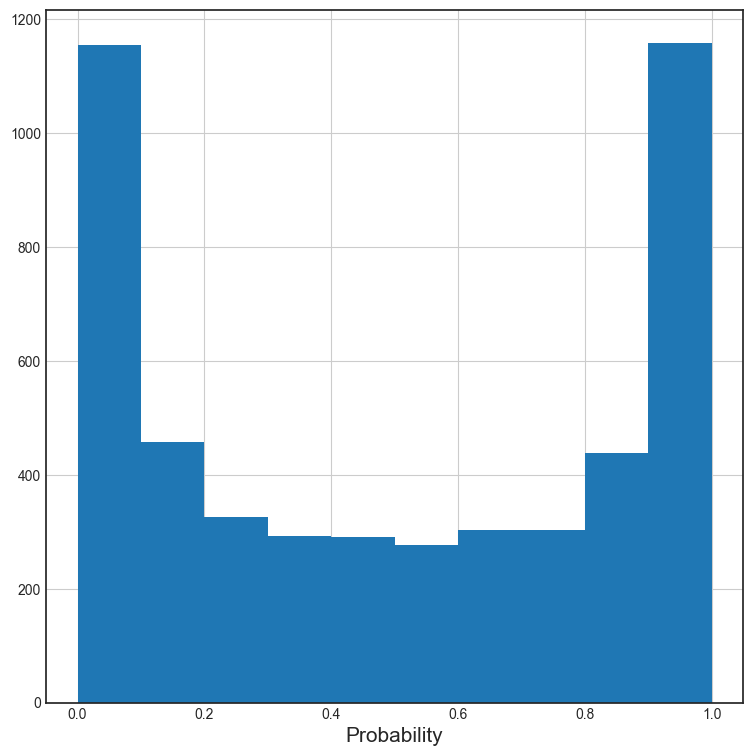

In [5]:
plt.hist(p)
plt.xlabel("Probability")
del p  # let's delete p so we don't use it accidentally
plt.show()

In [6]:
# create the range of x values we want to look at later
x_predict = np.arange(x.min().round(2), x.max().round(2), 0.005).reshape(-1, 1)

### Plot the generated data

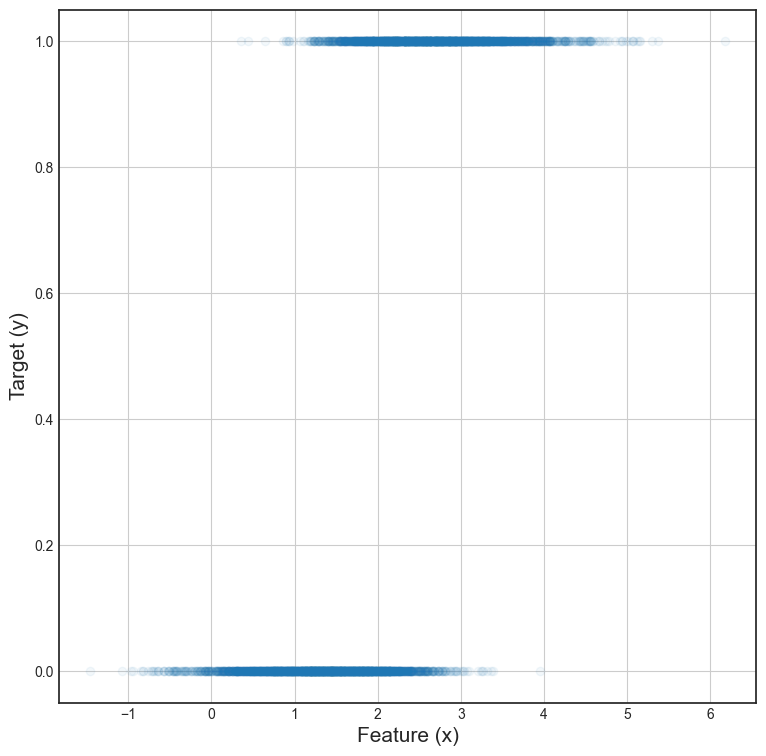

In [7]:
plt.scatter(x, y, alpha=0.05)
plt.xlabel("Feature (x)")
plt.ylabel("Target (y)")
plt.show()

<br><br>

## Linear model

### with `sklearn`

In [8]:
model_linear = sklearn.linear_model.LinearRegression()
model_linear.fit(x, y)
model_linear.coef_, model_linear.intercept_

(array([0.34951902]), -0.20872838871655586)

### Predict outcomes and plot result

In [9]:
def predict_plot(m, x, x_true, y_true, title="", lims=None, proba=False):
    plt.scatter(x_true, y_true, alpha=0.2, label="True")
    plt.plot(x, m.predict(x), label="Predicted", c="darkorange", linewidth=3)
    if proba:
        plt.plot(
            x,
            m.predict_proba(x)[:, 1],
            label="Predicted Probability",
            c="magenta",
            linewidth=3,
        )
        plt.hlines(
            y=0.5,
            xmin=x.min(),
            xmax=x.max(),
            colors="grey",
            linestyles="--",
            linewidth=1,
        )
    plt.xlabel("Feature (x)")
    plt.ylabel("Target (y)")
    plt.legend()
    plt.title(title)
    if lims:
        plt.xlim(lims[0])
        plt.ylim(lims[1])
    plt.show()

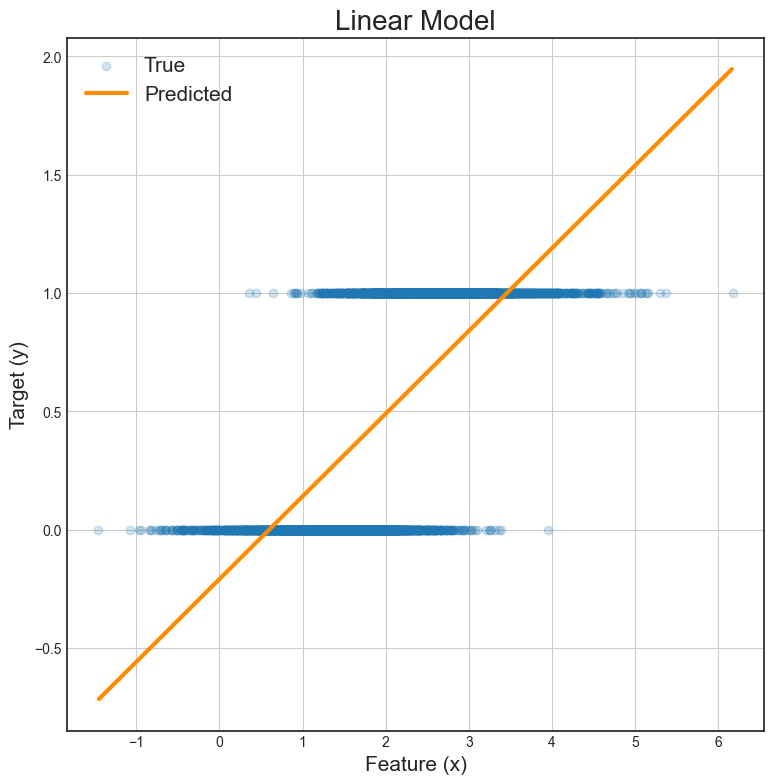

In [10]:
predict_plot(model_linear, x_predict, x, y, "Linear Model")

<br><br>

## Logistic Regression

- outcomes can only be 0 and 1
- model the probability of class membership
- given a probability threshold, we can turn probabilities in to class assignments

### Logistic function

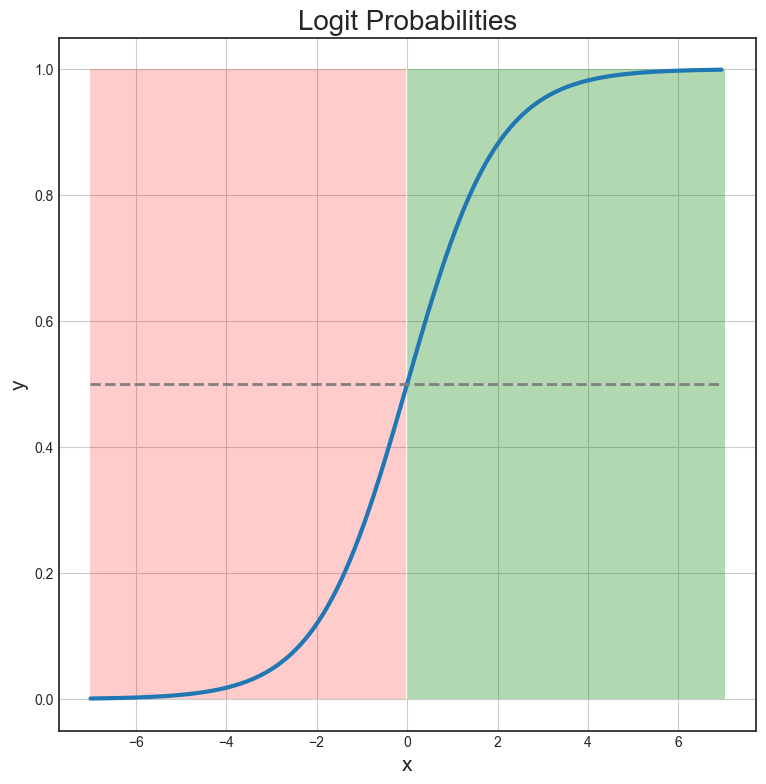

In [11]:
sample_x = np.arange(-7, 7, 0.05)
sample_y = 1 / (1 + np.exp(-sample_x))
fig, ax = plt.subplots(1)
ax.plot(sample_x, sample_y, linewidth=3)
plt.hlines(
    y=0.5,
    xmin=sample_x.min(),
    xmax=sample_x.max(),
    colors="grey",
    linestyles="--",
    linewidth=2,
)
delta = 0.02
ax.add_patch(
    matplotlib.patches.Rectangle(
        (-7, 0), 7-delta, 1, linewidth=0, facecolor="r", edgecolor="r", alpha=0.2
    )
)
ax.add_patch(
    matplotlib.patches.Rectangle(
        (delta, 0), 7, 1, linewidth=0, facecolor="g", edgecolor="g", alpha=0.3
    )
)
plt.title("Logit Probabilities")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### with `sklearn`

In [12]:
model_logistic = sklearn.linear_model.LogisticRegression(C=1e9)
result_logistic = model_logistic.fit(x, y)
result_logistic.intercept_, result_logistic.coef_

(array([-6.27042526]), array([[3.10679828]]))

In [13]:
# compare this to the true parameters, all looks good :)
B

[-6, 3]

### with `statsmodels`

In [14]:
sm_logit = sm.Logit(y, sm.add_constant(x))
result_sm_logit = sm_logit.fit()
print(result_sm_logit.summary())

Optimization terminated successfully.
         Current function value: 0.353528
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4998
Method:                           MLE   Df Model:                            1
Date:                Wed, 21 Sep 2022   Pseudo R-squ.:                  0.4899
Time:                        20:18:06   Log-Likelihood:                -1767.6
converged:                       True   LL-Null:                       -3465.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.2705      0.182    -34.467      0.000      -6.627      -5.914
x1             3.1068      0.

### Predict outcomes and plot result

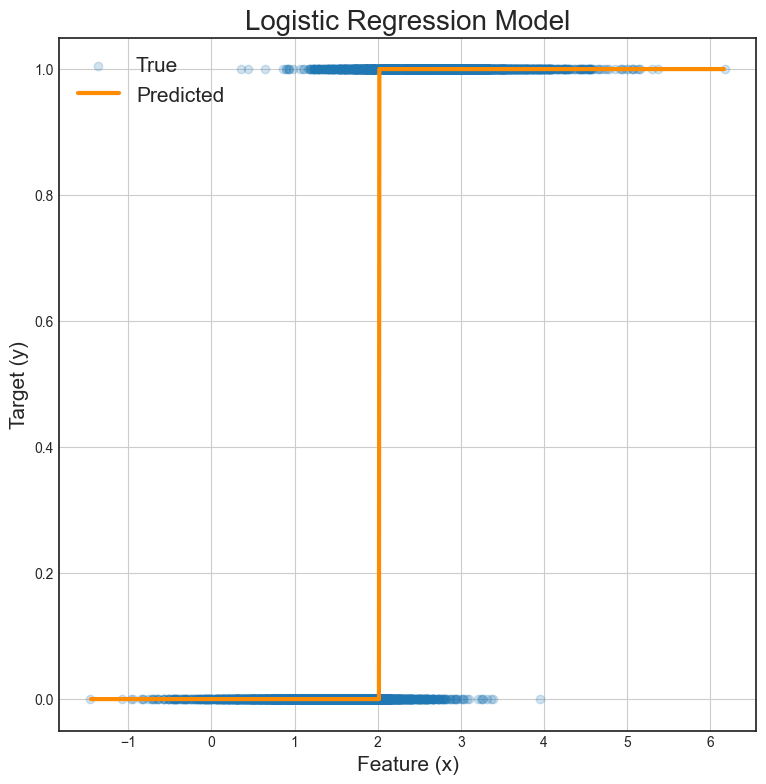

In [15]:
predict_plot(model_logistic, x_predict, x, y, "Logistic Regression Model")

### Let's use probabilities in the plot

The probability threshold of 0.5 forms the decision boundary, i.e., the point along `x` where it is equally likely that a sample belong to class 1 and class 0. This point is often called the decision boundary.

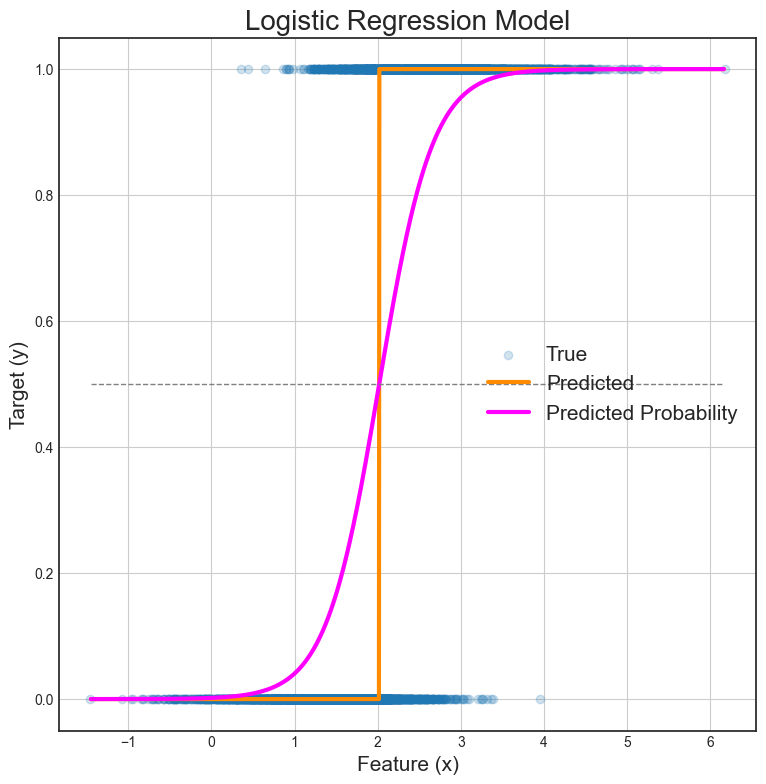

In [16]:
predict_plot(model_logistic, x_predict, x, y, "Logistic Regression Model", proba=True)

<br><br>

## Logit Widget

Play a little bit with the two parameters (intercept `b0` and slope `b1`, these are equivalent to `B` above) to convince yourself about how the parameters affect the shape of the Logit.

In [17]:
def logit_plot(b0, b1):
    x = np.arange(-7, 7, 0.05)
    z = b0 + b1 * x  # latent variable
    p = 1 / (1 + np.exp(-z))  # probability (of sample being in class 1)
    plt.plot(x, p, c="blue", linewidth=3)
    plt.hlines(y=0.5, xmin=-7, xmax=7, colors="grey", linestyles="--", linewidth=1)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [18]:
IPython.display.display(
    ipywidgets.interactive(
        logit_plot,
        b0=(-10, 10),
        b1=(-5, 10),
    )
)

interactive(children=(IntSlider(value=0, description='b0', max=10, min=-10), IntSlider(value=2, description='b…

<br>
<br>

# SELF STUDY

## What about more complex classification problems?

### Data generation

In [19]:
N = 1_000
np.random.seed(501)
x1 = np.random.uniform(-2, 2, (N, 1))
x2 = np.random.uniform(-2, 2, (N, 1))
x = np.hstack([x1, x2]) ** 2
y = ((x1**2 + x2**2) < 1).astype(int).flatten()

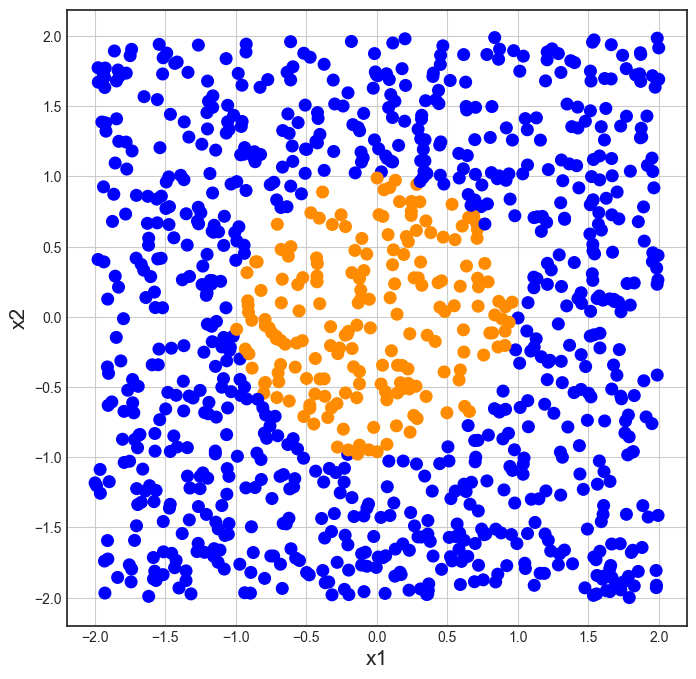

In [20]:
# cmap_2 = matplotlib.colors.ListedColormap(sns.color_palette("Paired")[1:3])
cmap_2 = matplotlib.colors.ListedColormap(["blue", "darkorange"])
fig, axes = plt.subplots(figsize=(8, 8))
plt.scatter(x1, x2, c=y, cmap=cmap_2, s=70)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

### Fit logistic regression with ___polynomial___ features

In [21]:
model_logistic = sklearn.linear_model.LogisticRegression()
result_logistic = model_logistic.fit(np.hstack([x1, x2]) ** 2, y)
result_logistic.intercept_, result_logistic.coef_

(array([5.4207463]), array([[-5.52825553, -5.58099957]]))

### Plot decision boundary

Before we had only one feature `x`, now we have two features `x1` and `x2`. The decision boundary now is not 1-dimensional (the point `x=2`) but 2-dimensional (a circle with radius 1).

In [22]:
n_samples = 1_000
_x1 = np.linspace(-2, 2, n_samples)
_x2 = np.linspace(-2, 2, n_samples)
_X1, _X2 = np.meshgrid(_x1, _x2)
_X = np.hstack([_X1.reshape(-1, 1) ** 2, _X2.reshape(-1, 1) ** 2])
Z = result_logistic.intercept_ + _X.dot(result_logistic.coef_.T)
yhat = result_logistic.predict(_X)

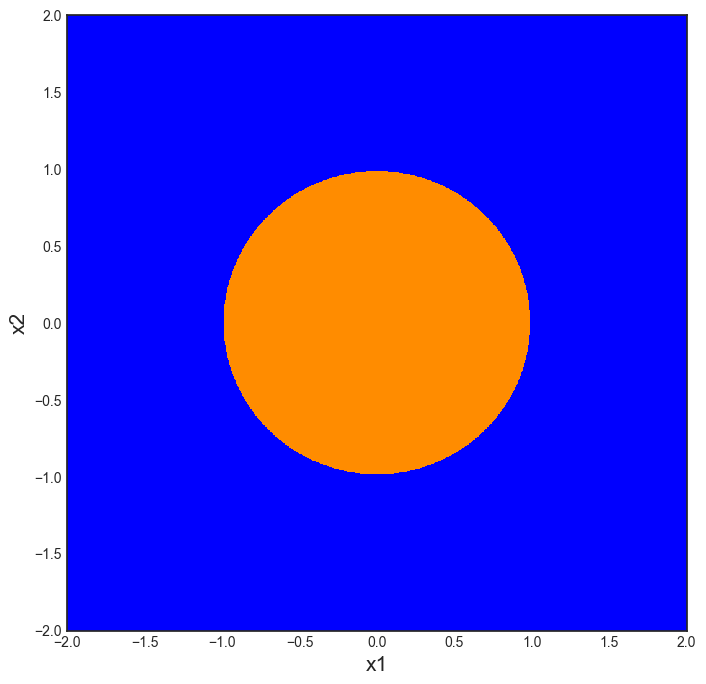

In [23]:
fig, axes = plt.subplots(figsize=(8, 8))
plt.pcolormesh(_X1, _X2, yhat.reshape(n_samples, n_samples), cmap=cmap_2)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

That's awesome, we are able to use a very simple model to predict this relatively complex decision boundary. The trick is to incorporate knowledge about the data distribution in our feature generation.
That is essentially what building good features is all about. We will see another example very similar to this when we discuss tree-based methods!

<br>

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/clapping.gif" width="400">


<br>
<br>
<br>

<b>Learning from Big Data</b> <br>
Sebastian Gabel <br>